In [18]:
import numpy as np
from PIL import Image
import pandas as pd
import os
import random

# Create folder
os.makedirs("synthetic_satellite", exist_ok=True)

image_data = []
for i in range(1000):
    # Randomly choose forest or deforested (balanced)
    label = random.choice(['forest', 'deforested'])
    if label == 'forest':
        # Mostly green image for forest
        img = np.zeros((128, 128, 3), dtype=np.uint8)
        img[..., 1] = np.random.randint(100, 220, (128, 128))   # Green channel
        img[..., 0] = np.random.randint(20, 90, (128, 128))     # Red channel
        img[..., 2] = np.random.randint(20, 90, (128, 128))     # Blue channel
    else:
        # Brown/greyish for deforested
        img = np.zeros((128, 128, 3), dtype=np.uint8)
        img[..., 0] = np.random.randint(80, 180, (128, 128))    # Red (brown)
        img[..., 1] = np.random.randint(60, 110, (128, 128))    # Green
        img[..., 2] = np.random.randint(40, 80, (128, 128))     # Blue

    img_name = f'image_{i:04d}.png'
    Image.fromarray(img).save(f'synthetic_satellite/{img_name}')
    image_data.append({'image_name': img_name, 'label': label})

# Make labels.csv
df = pd.DataFrame(image_data)
df.to_csv('labels.csv', index=False)

print("Synthetic dataset (images + CSV) ready!")
print("Images in: synthetic_satellite/")
print("Labels file: labels.csv")


Synthetic dataset (images + CSV) ready!
Images in: synthetic_satellite/
Labels file: labels.csv


Step 1: Preprocess Images and Labels

In [19]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
IMG_FOLDER = 'synthetic_satellite'
LABELS_FILE = 'labels.csv'

# Load CSV
df = pd.read_csv(LABELS_FILE)

# Map labels to numbers
label_map = {'forest': 0, 'deforested': 1}
df['label_idx'] = df['label'].map(label_map)

# Split into train/test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_idx'])

# Function to load and normalize images
def load_images(df):
    imgs = []
    labels = []
    for _, row in df.iterrows():
        img = Image.open(os.path.join(IMG_FOLDER, row['image_name']))
        img = img.resize((64, 64))  # Resize for faster training
        img = np.asarray(img) / 255.0
        imgs.append(img)
        labels.append(row['label_idx'])
    return np.array(imgs), np.array(labels)

X_train, y_train = load_images(train_df)
X_test, y_test = load_images(test_df)

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)


Train set: (800, 64, 64, 3) (800,)
Test set: (200, 64, 64, 3) (200,)


Step 2: Train a Simple CNN for Land Classification

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=8, validation_data=(X_test, y_test))


Epoch 1/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9229 - loss: 0.3825 - val_accuracy: 1.0000 - val_loss: 1.1642e-04
Epoch 2/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 4.1328e-05 - val_accuracy: 1.0000 - val_loss: 1.1095e-06
Epoch 3/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 1.0000 - loss: 8.6902e-07 - val_accuracy: 1.0000 - val_loss: 5.1571e-07
Epoch 4/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 4.9480e-07 - val_accuracy: 1.0000 - val_loss: 4.2701e-07
Epoch 5/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 1.0000 - loss: 4.1418e-07 - val_accuracy: 1.0000 - val_loss: 3.7606e-07
Epoch 6/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.7327e-07 - val_accuracy: 1.0000 - val_loss: 3.3531e-07
Epoch 7/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 1.0000 - loss: 3.2888e-07 - val_accuracy: 1.0000 - val_loss: 3.0348e-07
Epoch 8/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy:

Step 3: Change Detection (Sequential Analysis)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Sample 1:
  Before (CNN): Deforested
  After  (CNN): Deforested
  No deforestation detected.


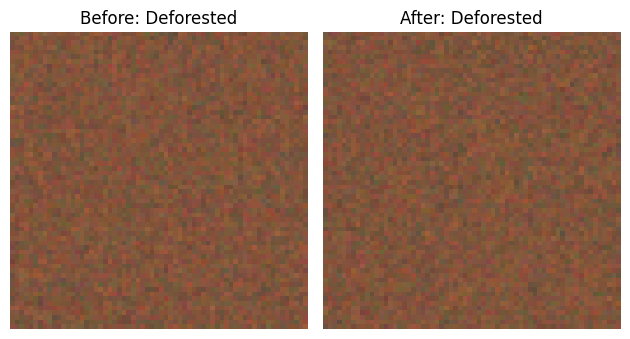


Sample 2:
  Before (CNN): Forest
  After  (CNN): Deforested
  >>> Deforestation detected!


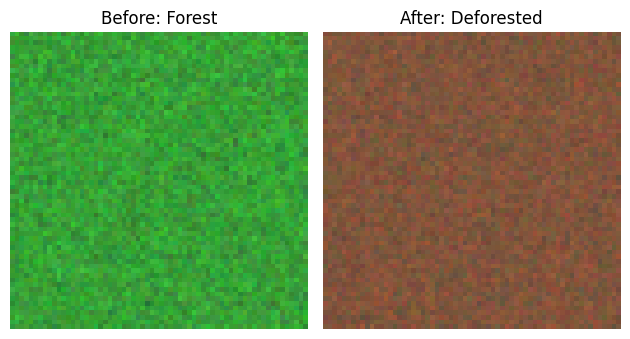


Sample 3:
  Before (CNN): Forest
  After  (CNN): Deforested
  >>> Deforestation detected!


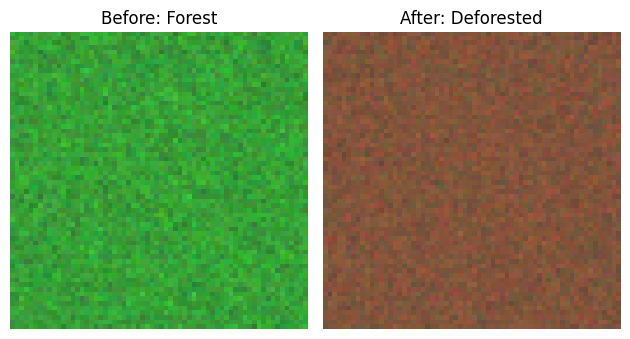


Sample 4:
  Before (CNN): Forest
  After  (CNN): Forest
  No deforestation detected.


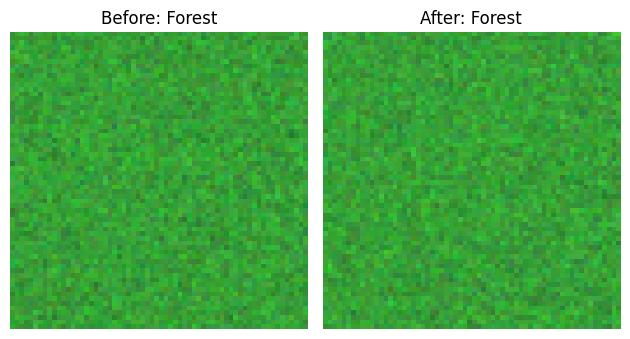


Sample 5:
  Before (CNN): Deforested
  After  (CNN): Forest
  No deforestation detected.


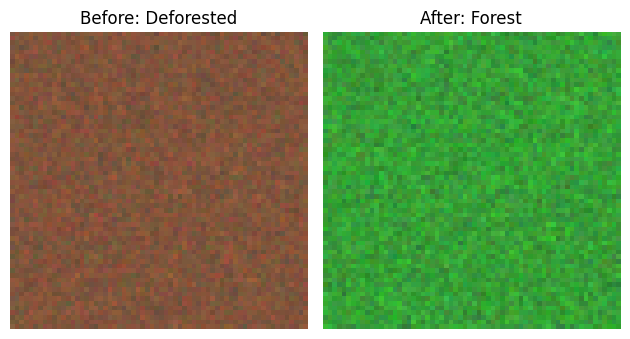


Sample 6:
  Before (CNN): Deforested
  After  (CNN): Forest
  No deforestation detected.


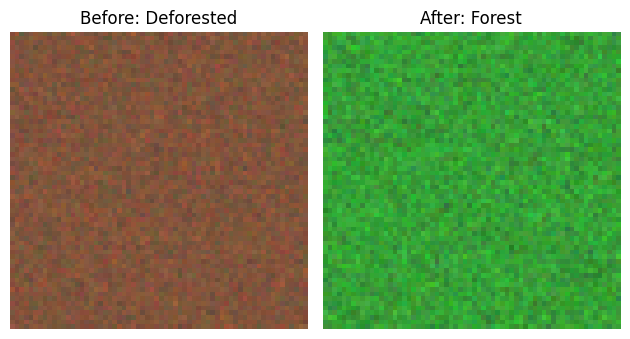


Sample 7:
  Before (CNN): Deforested
  After  (CNN): Deforested
  No deforestation detected.


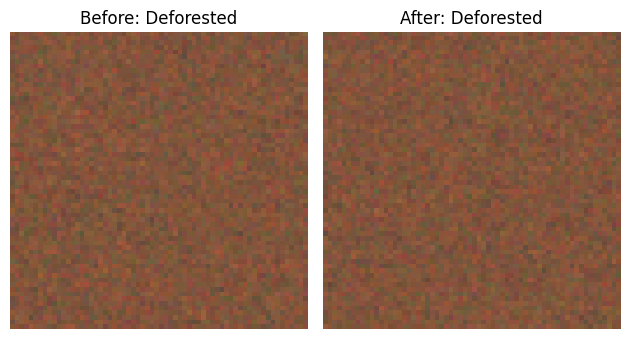


Sample 8:
  Before (CNN): Deforested
  After  (CNN): Forest
  No deforestation detected.


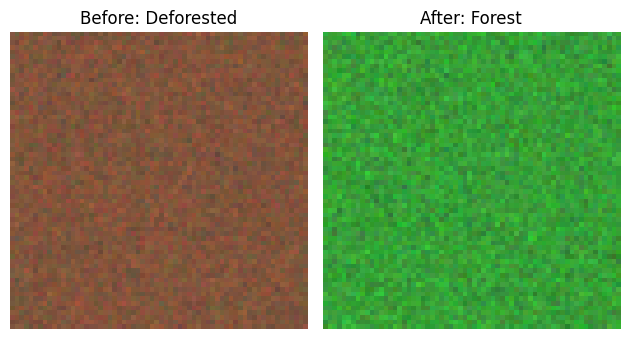


Sample 9:
  Before (CNN): Forest
  After  (CNN): Deforested
  >>> Deforestation detected!


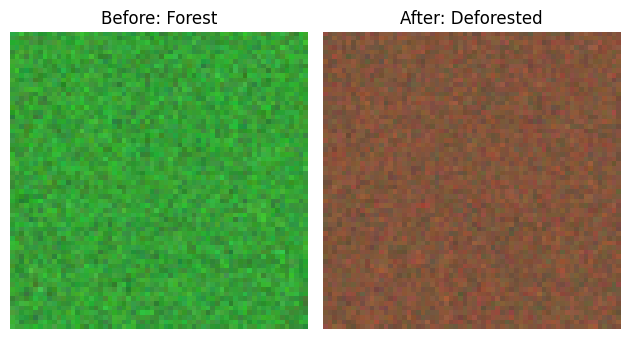


Sample 10:
  Before (CNN): Forest
  After  (CNN): Forest
  No deforestation detected.


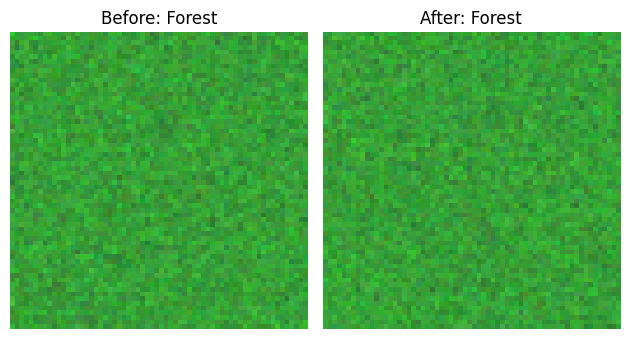

In [15]:
import numpy as np

# Suppose you already have your trained CNN model as 'model'
# And test images as X_test

# Select "before" and "after" pairs (for demo, just split test set)
before_imgs = X_test[:10]
after_imgs = X_test[10:20]

# Get CNN predictions for before and after images
before_preds = (model.predict(before_imgs) > 0.5).astype(int).flatten()  # 0=forest, 1=deforested
after_preds = (model.predict(after_imgs) > 0.5).astype(int).flatten()

# Optionally, get human-readable labels for visualization
def label_text(idx): return "Forest" if idx==0 else "Deforested"

# Now check for change: Forest → Deforested
for i in range(len(before_imgs)):
    print(f"\nSample {i+1}:")
    print(f"  Before (CNN): {label_text(before_preds[i])}")
    print(f"  After  (CNN): {label_text(after_preds[i])}")

    if before_preds[i]==0 and after_preds[i]==1:
        print("  >>> Deforestation detected!")
    else:
        print("  No deforestation detected.")

    # Visualization (optional)
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(before_imgs[i])
    axs[0].set_title(f"Before: {label_text(before_preds[i])}")
    axs[0].axis('off')
    axs[1].imshow(after_imgs[i])
    axs[1].set_title(f"After: {label_text(after_preds[i])}")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()


Step 4: Visualization of Environmental Change

In [20]:
import matplotlib.pyplot as plt

def plot_change(before, after, pred_before, pred_after):
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(before)
    axs[0].set_title(f"Before: {'Forest' if pred_before==0 else 'Deforested'}")
    axs[0].axis('off')
    axs[1].imshow(after)
    axs[1].set_title(f"After: {'Forest' if pred_after==0 else 'Deforested'}")
    axs[1].axis('off')

    # Highlight if deforestation happened
    if pred_before == 0 and pred_after == 1:
        axs[2].text(0.5, 0.5, 'DEFORESTATION ALERT!', fontsize=20, color='red',
                    ha='center', va='center', weight='bold')
    else:
        axs[2].text(0.5, 0.5, 'No Major Change', fontsize=18, color='green',
                    ha='center', va='center')
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()


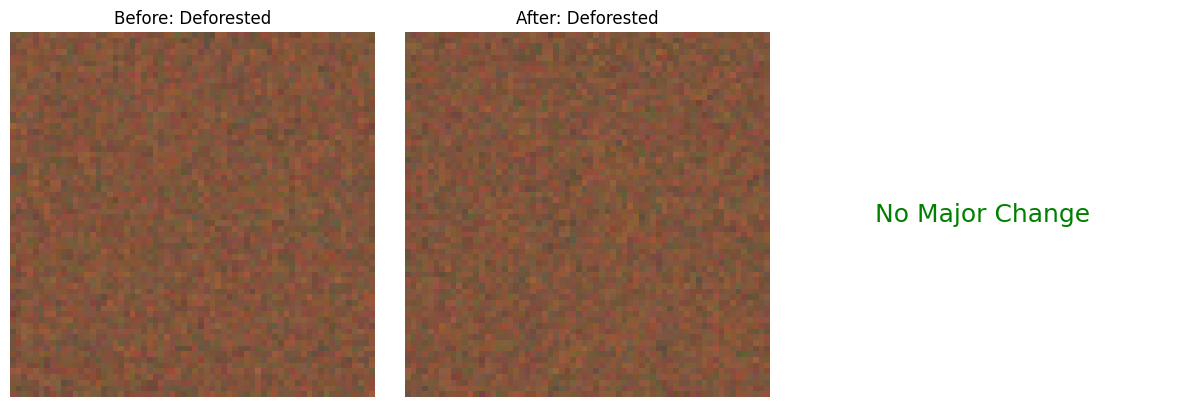

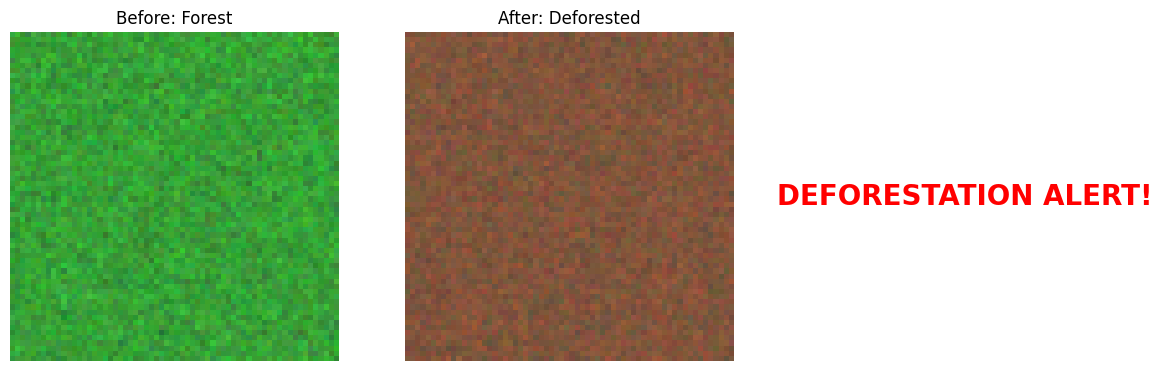

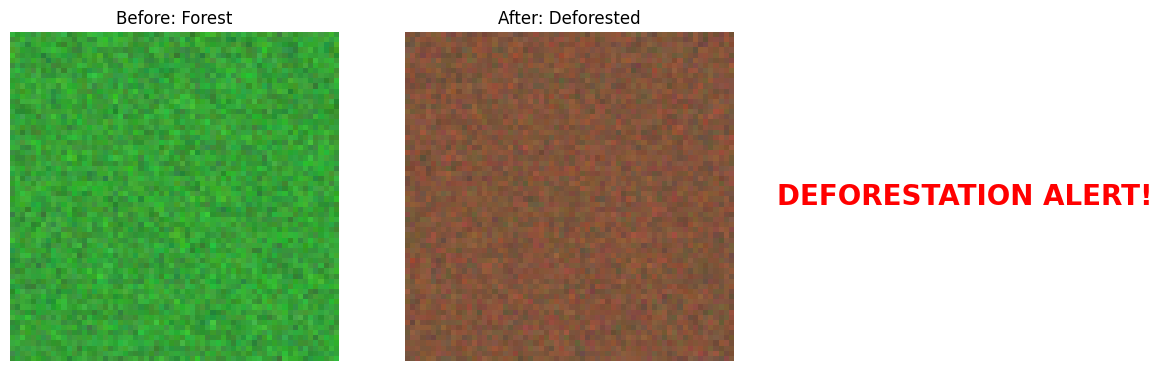

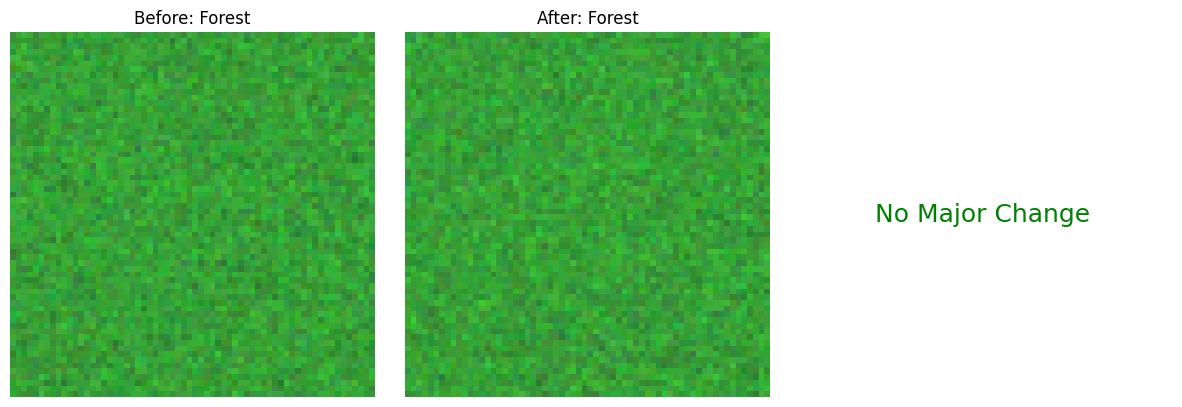

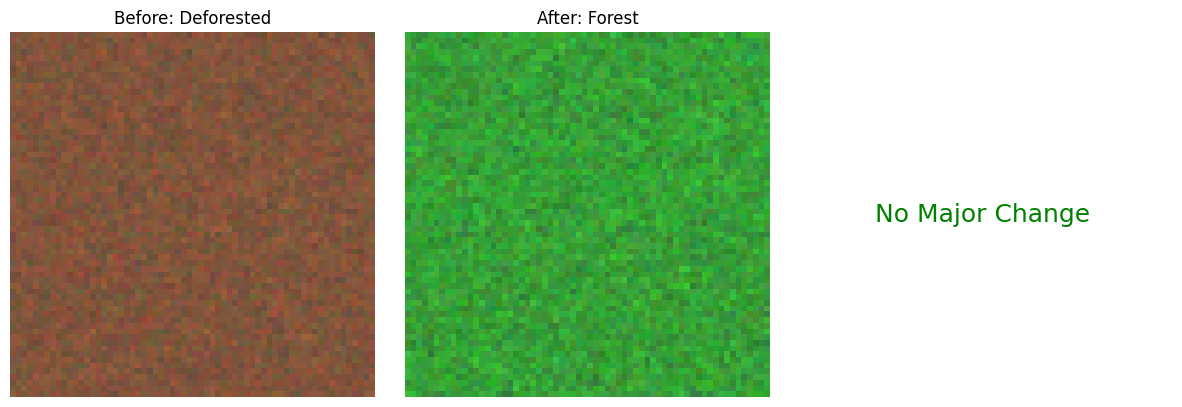

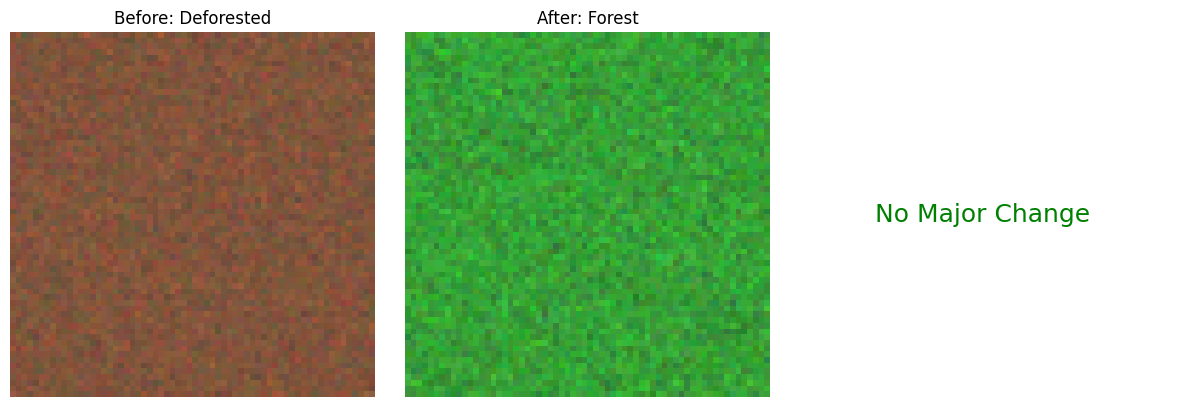

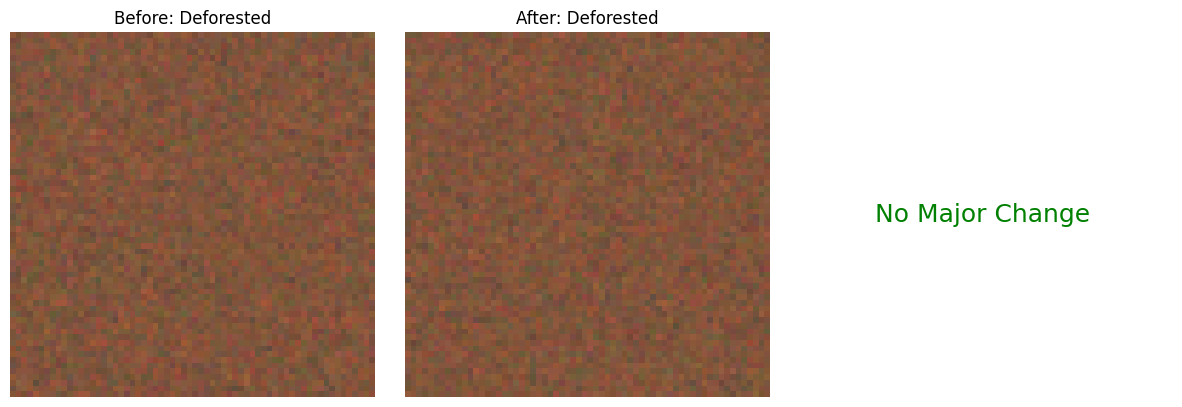

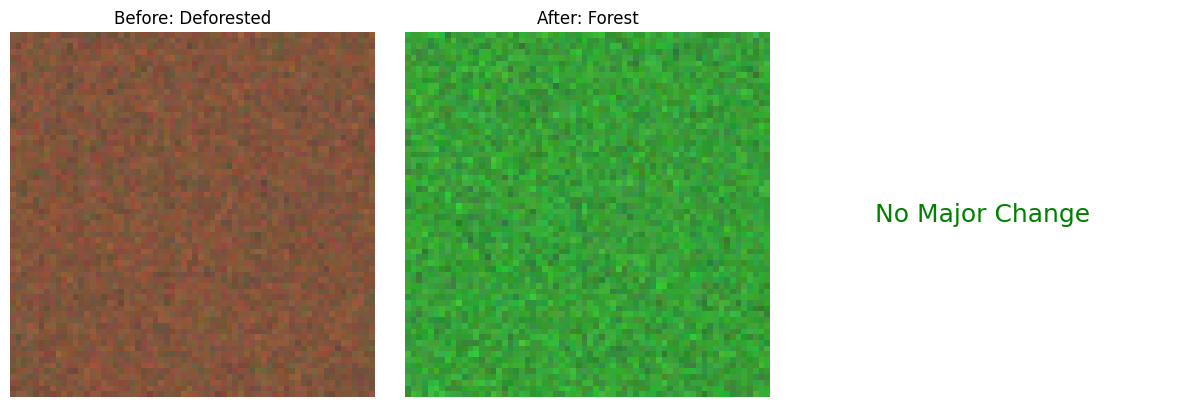

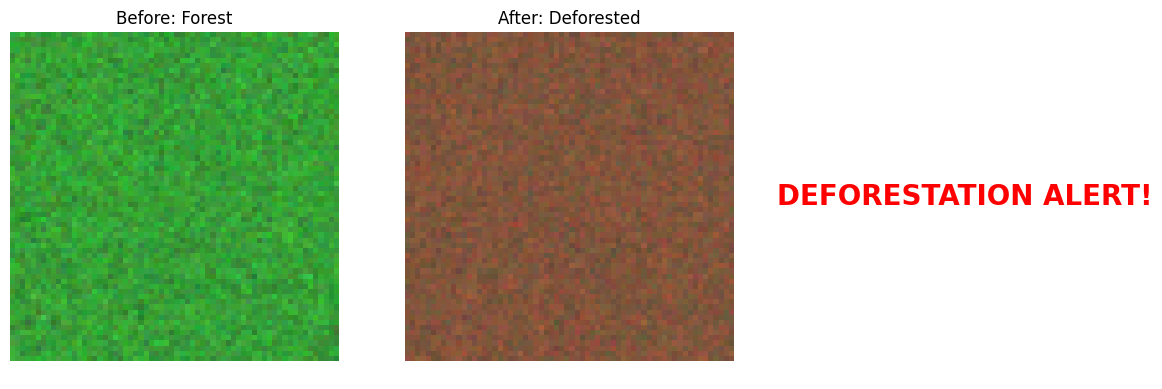

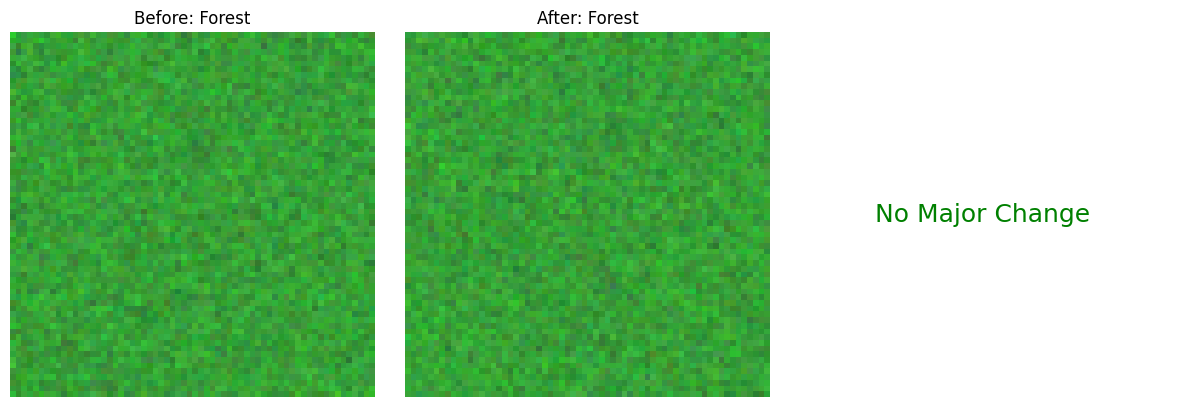

In [21]:
# Simulated predictions for example
for i in range(10): # Change the range from 15 to 10
    plot_change(before_imgs[i], after_imgs[i], before_labels[i], after_labels[i])

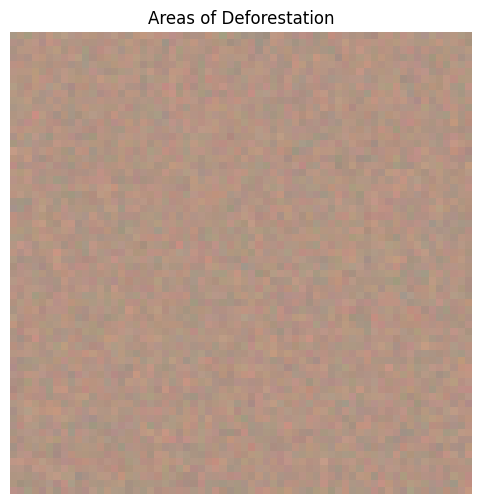

In [22]:
# Suppose mask_before and mask_after are 2D arrays (1=forest, 0=deforested)
# We will simulate these based on the example images and labels
# For demonstration, let's take the first image from before_imgs and after_imgs
before = before_imgs[0] # Use the first 'before' image from the earlier defined list
after = after_imgs[0]   # Use the first 'after' image

# Simulate predictions/masks based on the labels for these specific images
# Assuming 1=forest and 0=deforested for the masks, opposite of label_idx
mask_before = 1 - before_labels[0] # 1 if forest (label_idx 0), 0 if deforested (label_idx 1)
mask_after = 1 - after_labels[0]   # 1 if forest (label_idx 0), 0 if deforested (label_idx 1)

# Create the difference mask: Forest lost (was forest, now deforested)
# This needs to be a 2D array of the same shape as the image (64x64)
# We can simulate a deforested area mask for this example if the condition is met
diff_mask = np.zeros((64, 64)) # Initialize with zeros (no change)

# If deforestation is simulated for this specific image pair, create a sample diff_mask
if mask_before == 1 and mask_after == 0:
    # Simulate a patch of deforestation, e.g., a square in the middle
    diff_mask[20:40, 20:40] = 1 # Set a central square to 1 (indicating change)


# Overlay on original image:
# Matplotlib's imshow expects the image data.
# For the overlay, we need the alpha to apply to the actual color map, not the data value itself.
# We create a mask that is only 1 where we want the overlay color (deforestation detected).
overlay_mask = np.zeros_like(before[:,:,0]) # Create a 2D mask same size as image (without color channels)
if mask_before == 1 and mask_after == 0:
     overlay_mask[20:40, 20:40] = 1 # Set the same area as before to 1

plt.figure(figsize=(6, 6)) # Optional: Adjust figure size
plt.imshow(before, alpha=1.0) # Plot the 'before' image
# Overlay the 'diff_mask' using a colormap for visualization
# We use the overlay_mask to control where the red color appears
plt.imshow(overlay_mask, cmap='Reds', alpha=0.4) # Red overlay where overlay_mask is 1
plt.title("Areas of Deforestation")
plt.axis('off')
plt.show()

In [23]:
import folium

# Center of area (example coordinates)
m = folium.Map(location=[-3.0, -60.0], zoom_start=7)

# Suppose change detected at these locations
change_locations = [(-3.1, -60.2), (-3.2, -60.1)]
for lat, lon in change_locations:
    folium.Marker([lat, lon], popup="Deforestation Detected", icon=folium.Icon(color='red')).add_to(m)

m.save('deforestation_map.html')


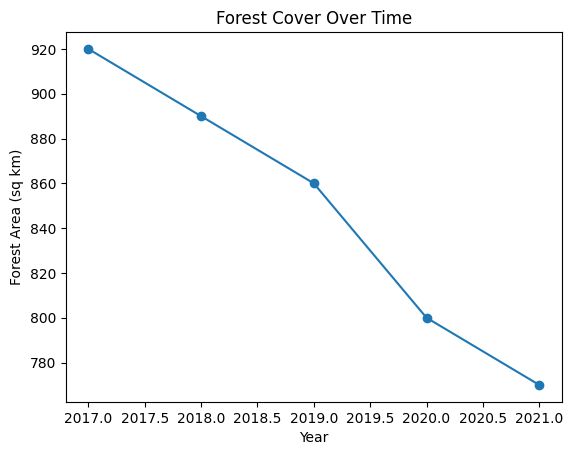

In [24]:
years = [2017, 2018, 2019, 2020, 2021]
forest_area = [920, 890, 860, 800, 770]  # Example in sq km
plt.plot(years, forest_area, marker='o')
plt.title("Forest Cover Over Time")
plt.xlabel("Year")
plt.ylabel("Forest Area (sq km)")
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Test Accuracy: 1.000


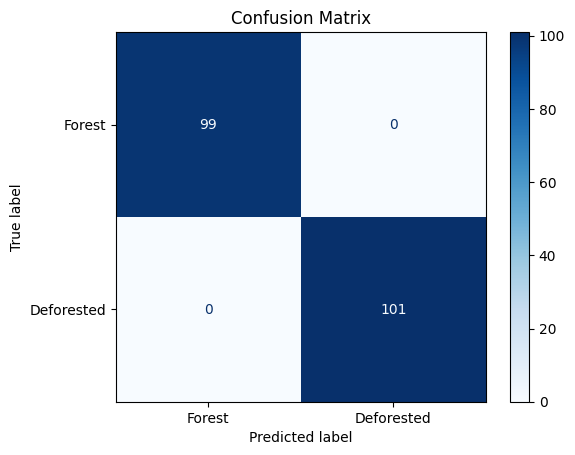

Classification Report:

              precision    recall  f1-score   support

      Forest       1.00      1.00      1.00        99
  Deforested       1.00      1.00      1.00       101

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



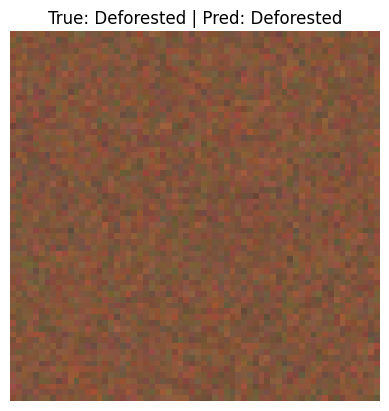

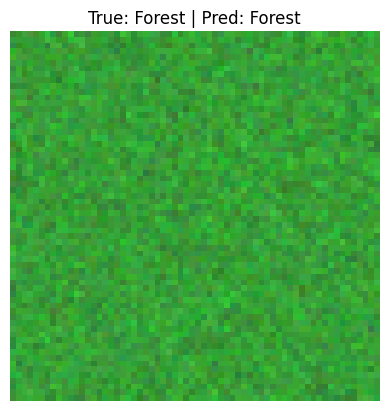

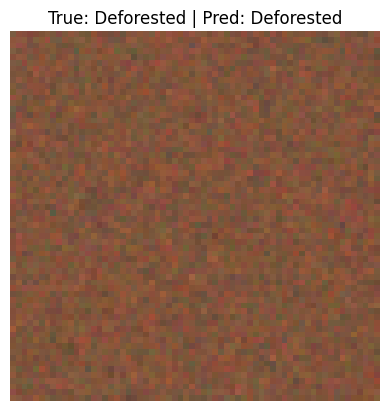

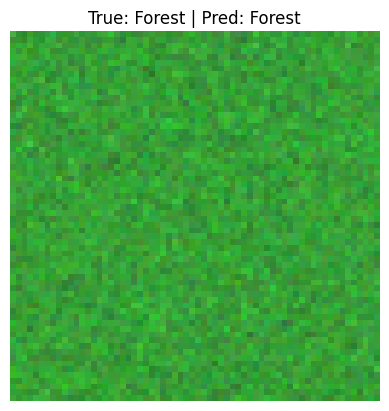

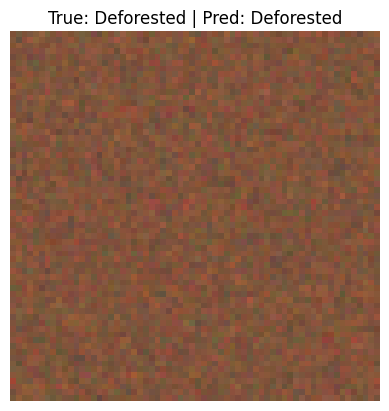

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Model predictions on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 1. Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Forest', 'Deforested'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 3. Classification Report (precision, recall, f1-score)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Forest', 'Deforested']))

# 4. (Optional) Show some predictions
for i in range(5):
    plt.imshow(X_test[i])
    plt.title(f"True: {'Forest' if y_test[i]==0 else 'Deforested'} | Pred: {'Forest' if y_pred[i]==0 else 'Deforested'}")
    plt.axis('off')
    plt.show()
